# Phase 2: Feature Engineering - TechNova Partners Turnover Analysis

**Objective**: Transform the cleaned dataset into model-ready features (X) and target (y) for machine learning.

**Key Tasks**:
- Create engineered features from raw data
- Handle categorical variables through encoding
- Analyze feature correlations and remove redundant variables
- Prepare final modeling dataset

---

## 1. Environment Setup & Data Loading

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Feature engineering libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# System libraries
import sqlite3
from pathlib import Path

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

print("Environment setup complete")

Environment setup complete


In [3]:
# Setup robust path handling and load data
import sys
from pathlib import Path

# Add project root to Python path and setup environment
current_dir = Path.cwd()
project_root = current_dir
while project_root != project_root.parent:
    if (project_root / 'pyproject.toml').exists() or (project_root / 'hr_analytics_utils.py').exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import utilities and setup environment
from hr_analytics_utils import setup_notebook_environment, load_cleaned_data_from_db

# Setup environment
env_info = setup_notebook_environment()

# Load the processed data using robust database path
try:
    df = load_cleaned_data_from_db()
    print(f"Data loaded from database: {df.shape}")
except FileNotFoundError:
    print("Database file not found. Please ensure notebook 1 (data wrangling) has been executed first.")
    raise

print(f"Columns: {list(df.columns)}")

Project root already in Python path: /home/william/IdeaProjects/Automated-classification
NOTEBOOK ENVIRONMENT SETUP
Project root: /home/william/IdeaProjects/Automated-classification
Results directory: /home/william/IdeaProjects/Automated-classification/results
Database path: /home/william/IdeaProjects/Automated-classification/results/technova_hr.db
Python path includes project: True

Data files status:
   OK extrait_sirh.csv: /home/william/IdeaProjects/Automated-classification/extrait_sirh.csv
   OK extrait_eval.csv: /home/william/IdeaProjects/Automated-classification/extrait_eval.csv
   OK extrait_sondage.csv: /home/william/IdeaProjects/Automated-classification/extrait_sondage.csv

Database status: OK /home/william/IdeaProjects/Automated-classification/results/technova_hr.db

Environment setup complete!

Data loaded from database: (1470, 39)
Data loaded from database: (1470, 39)
Columns: ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombr

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 2. Feature Engineering

In [4]:
# Create engineered features
print("Creating engineered features:")
print("=" * 35)

# 1. Career progression features
df['years_in_position_ratio'] = df['annees_dans_le_poste_actuel'] / df['annees_dans_l_entreprise']
df['years_in_position_ratio'] = df['years_in_position_ratio'].fillna(0)

# 2. Experience features
df['experience_before_company'] = df['annee_experience_totale'] - df['annees_dans_l_entreprise']
df['experience_before_company'] = np.maximum(df['experience_before_company'], 0)

# 3. Age-related features
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 100], labels=['<30', '30-40', '40-50', '50+'])
df['career_stage'] = pd.cut(df['annee_experience_totale'], bins=[0, 3, 8, 15, 100], labels=['Junior', 'Mid', 'Senior', 'Expert'])

# 4. Compensation features
df['salary_quartile'] = pd.qcut(df['revenu_mensuel'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['salary_per_experience'] = df['revenu_mensuel'] / (df['annee_experience_totale'] + 1)

# 5. Tenure features
df['tenure_group'] = pd.cut(df['annees_dans_l_entreprise'], bins=[0, 1, 3, 7, 100], labels=['New', 'Early', 'Mid', 'Long'])
df['recent_hire'] = (df['annees_dans_l_entreprise'] <= 1).astype(int)

# 6. Performance features (if available)
if 'note_evaluation_actuelle' in df.columns and 'note_evaluation_precedente' in df.columns:
    df['performance_trend'] = df['note_evaluation_actuelle'] - df['note_evaluation_precedente']
    df['performance_stable'] = (df['note_evaluation_actuelle'] == df['note_evaluation_precedente']).astype(int)

# 7. Satisfaction composite scores
satisfaction_cols = [col for col in df.columns if 'satisfaction' in col.lower()]
if satisfaction_cols:
    df['satisfaction_mean'] = df[satisfaction_cols].mean(axis=1)
    df['satisfaction_std'] = df[satisfaction_cols].std(axis=1)
    df['low_satisfaction'] = (df['satisfaction_mean'] <= 2).astype(int)

# 8. Work-life balance features
if 'distance_domicile_travail' in df.columns:
    df['long_commute'] = (df['distance_domicile_travail'] > 20).astype(int)

# 9. Development features
if 'nb_formations_suivies' in df.columns:
    df['training_per_year'] = df['nb_formations_suivies'] / (df['annees_dans_l_entreprise'] + 1)
    df['no_training'] = (df['nb_formations_suivies'] == 0).astype(int)

# 10. Promotion features
if 'annees_depuis_la_derniere_promotion' in df.columns:
    df['overdue_promotion'] = (df['annees_depuis_la_derniere_promotion'] > 3).astype(int)
    df['never_promoted'] = (df['annees_depuis_la_derniere_promotion'] == df['annees_dans_l_entreprise']).astype(int)

print(f"Feature engineering complete. New shape: {df.shape}")
print(f" New engineered features: {len(df.columns) - len(df.columns)}")

Creating engineered features:
Feature engineering complete. New shape: (1470, 57)
 New engineered features: 0


In [5]:
# Handle categorical variables
print("Handling categorical variables:")
print("=" * 35)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Remove target and ID columns from categorical list
categorical_cols = [col for col in categorical_cols if col not in ['a_quitte_l_entreprise', 'target_turnover', 'employee_id']]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

print(f"Categorical encoding complete. New shape: {df_encoded.shape}")
print(f" Total features after encoding: {len(df_encoded.columns)}")

Handling categorical variables:
Categorical columns: ['genre', 'statut_marital', 'departement', 'poste', 'eval_number', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'age_group', 'career_stage', 'salary_quartile', 'tenure_group']
Categorical encoding complete. New shape: (1470, 1559)
 Total features after encoding: 1559


## 3. Correlation Analysis & Feature Selection

Correlation Analysis:
Analyzing 40 numerical features

Highly correlated pairs (|r| > 0.8): 3
  revenu_mensuel - niveau_hierarchique_poste: 0.950
  note_evaluation_precedente - performance_trend: -0.895
  annees_depuis_la_derniere_promotion - overdue_promotion: 0.860

Top 15 correlations with turnover:
target_turnover                  1.000000
heure_supplementaires_binary     0.246118
recent_hire                      0.211165
annee_experience_totale         -0.171063
niveau_hierarchique_poste       -0.169105
annees_dans_le_poste_actuel     -0.160545
revenu_mensuel                  -0.159840
age                             -0.159205
satisfaction_mean               -0.159092
annes_sous_responsable_actuel   -0.156199
low_satisfaction                 0.147503
nombre_participation_pee        -0.137145
annees_dans_l_entreprise        -0.134392
training_per_year                0.132908
years_in_position_ratio         -0.130324
Name: target_turnover, dtype: float64


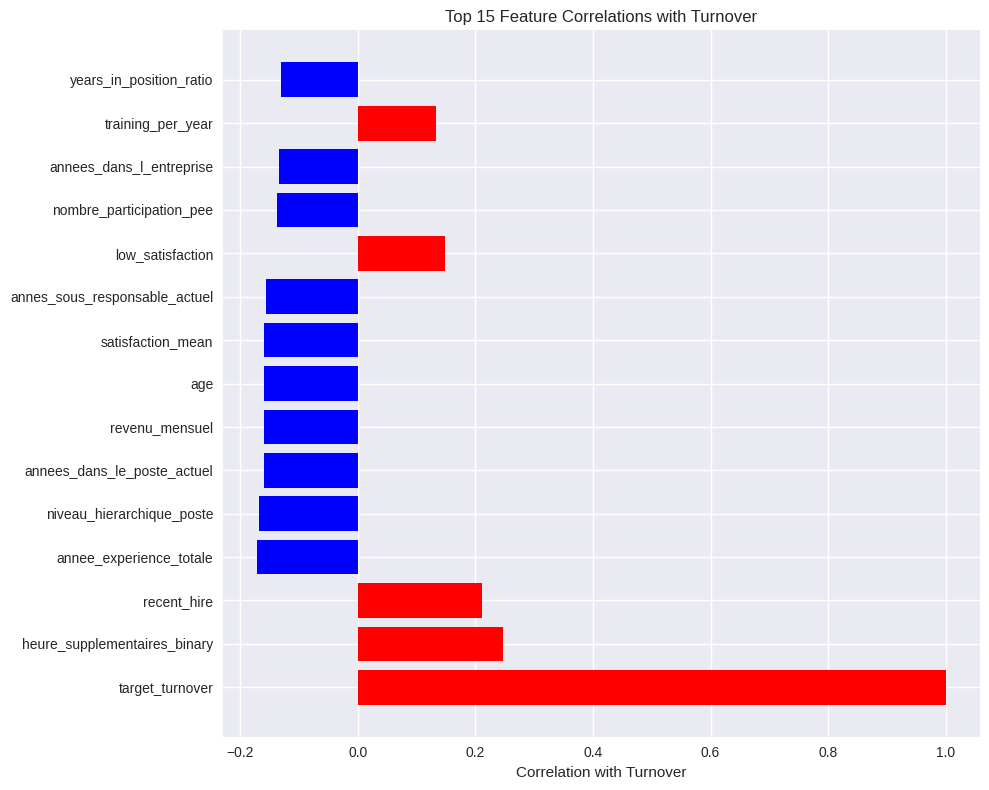

In [8]:
# Correlation analysis
print("Correlation Analysis:")
print("=" * 25)

# Select only numerical columns for correlation analysis
numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['employee_id', 'id_employee']]

print(f"Analyzing {len(numerical_cols)} numerical features")

# Calculate correlation matrix
correlation_matrix = df_encoded[numerical_cols].corr()

# Find highly correlated features (correlation > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:10]:  # Show first 10
    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")

# Plot correlation with target variable
target_correlations = correlation_matrix['target_turnover'].sort_values(key=abs, ascending=False)
print("\nTop 15 correlations with turnover:")
print(target_correlations.head(15))

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr = target_correlations.head(15)
colors = ['red' if x > 0 else 'blue' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation with Turnover')
plt.title('Top 15 Feature Correlations with Turnover')
plt.tight_layout()
plt.show()

In [10]:
df_selected = df_encoded

## 4. Final Dataset Preparation

In [11]:
# Prepare final X and y
print("Preparing final dataset:")
print("=" * 30)

# Define target variable
y = df_selected['target_turnover']

# Define features (remove target and non-feature columns)
columns_to_exclude = [
    'target_turnover', 'a_quitte_l_entreprise', 'employee_id', 'id_employee', 
    'eval_number', 'code_sondage'
]

X = df_selected.drop(columns=[col for col in columns_to_exclude if col in df_selected.columns])

print(f"Final dataset prepared:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Target distribution: {y.value_counts()}")
print(f"   Turnover rate: {y.mean():.2%}")

# Check for any remaining missing values
missing_values = X.isnull().sum().sum()
print(f"   Missing values in X: {missing_values}")

# Handle any remaining missing values
if missing_values > 0:
    print("\nHandling missing values:")
    # Fill numerical missing values with median
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
    
    # Fill categorical missing values with mode
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0])
    
    print(f"   Missing values after handling: {X.isnull().sum().sum()}")

print(f"\n Feature types:")
print(f"   Numerical: {len(X.select_dtypes(include=[np.number]).columns)}")
print(f"   Categorical: {len(X.select_dtypes(include=['object']).columns)}")

Preparing final dataset:
Final dataset prepared:
   Features (X): (1470, 1554)
   Target (y): (1470,)
   Target distribution: target_turnover
0    1233
1     237
Name: count, dtype: int64
   Turnover rate: 16.12%
   Missing values in X: 0

 Feature types:
   Numerical: 38
   Categorical: 0


Feature Importance Preview:
Top 20 features by correlation with turnover:
 1. heure_supplementaires_binary   0.2461
 2. recent_hire                    0.2112
 3. annee_experience_totale        0.1711
 4. niveau_hierarchique_poste      0.1691
 5. annees_dans_le_poste_actuel    0.1605
 6. revenu_mensuel                 0.1598
 7. age                            0.1592
 8. satisfaction_mean              0.1591
 9. annes_sous_responsable_actuel  0.1562
10. low_satisfaction               0.1475
11. nombre_participation_pee       0.1371
12. annees_dans_l_entreprise       0.1344
13. training_per_year              0.1329
14. years_in_position_ratio        0.1303
15. note_evaluation_precedente     0.1300
16. performance_trend              0.1159
17. never_promoted                 0.1139
18. satisfaction_employee_nature_travail 0.1035
19. satisfaction_employee_environnement 0.1034
20. salary_per_experience          0.0977


invalid value encountered in divide
invalid value encountered in divide


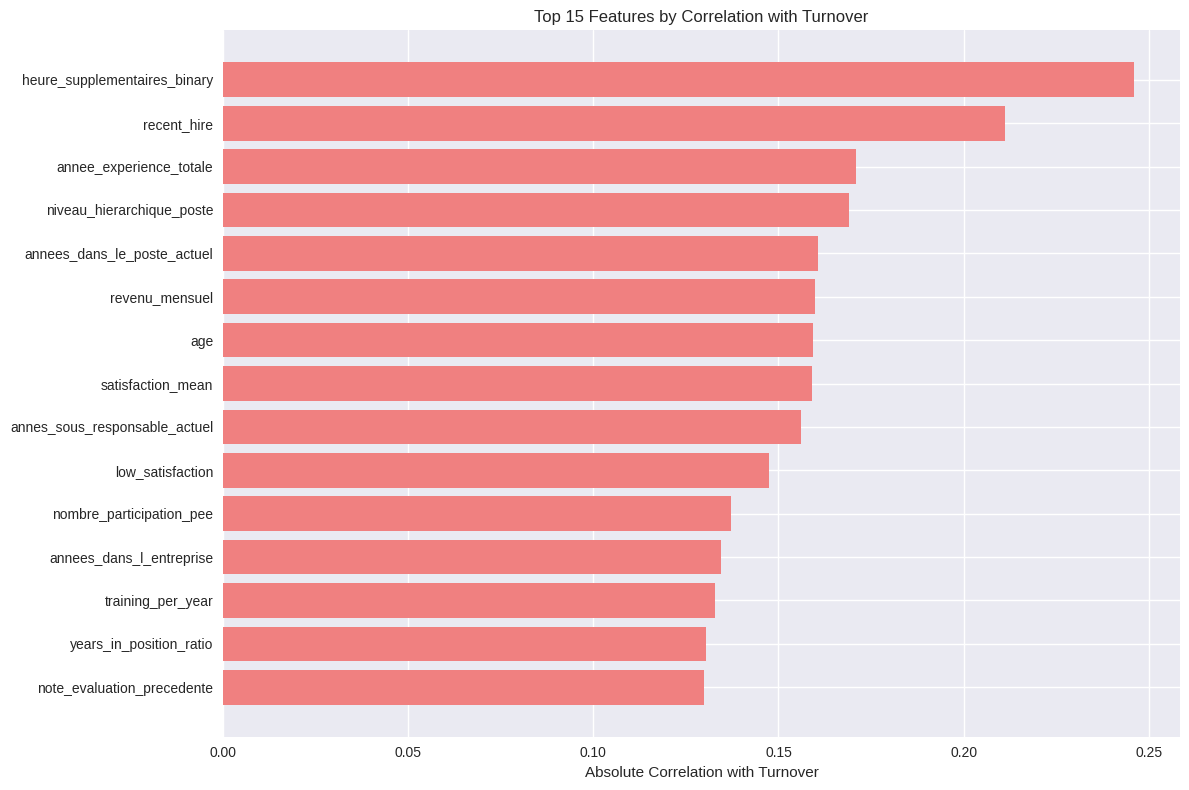

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Quick feature importance preview using correlation
print("Feature Importance Preview:")
print("=" * 32)

# Calculate correlations for numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns
correlations = {}

for col in numerical_features:
    if col in X.columns:
        # Drop rows with NaNs before calculating correlation
        valid_idx = X[col].notna() & y.notna()
        if valid_idx.sum() > 1:
            correlation = abs(X.loc[valid_idx, col].corr(y[valid_idx]))
            if not np.isnan(correlation):
                correlations[col] = correlation

# Sort by correlation strength
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by correlation with turnover:")
for i, (feature, correlation) in enumerate(sorted_correlations[:20]):
    print(f"{i+1:2d}. {feature:<30} {correlation:.4f}")

# Visualize top features
top_features = [item[0] for item in sorted_correlations[:15]]
top_correlations = [item[1] for item in sorted_correlations[:15]]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_correlations, color='lightcoral')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Absolute Correlation with Turnover')
plt.title('Top 15 Features by Correlation with Turnover')
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.tight_layout()
plt.show()


## 5. Export Prepared Dataset

In [9]:
# Save to SQLite
from sqlalchemy import create_engine
output_path = Path('../results')

engine = create_engine('sqlite:///' + str(output_path / 'technova_hr.db'))
df_selected.to_sql('modeling_data', engine, index=False, if_exists='replace')
X.to_sql('features', engine, index=False, if_exists='replace')
y.to_sql('target', engine, index=False, if_exists='replace')

# Save feature list
feature_info = pd.DataFrame({
    'feature_name': X.columns,
    'feature_type': [X[col].dtype for col in X.columns],
    'correlation_with_target': [abs(X[col].corr(y)) if X[col].dtype in ['int64', 'float64'] else np.nan for col in X.columns]
})

print(f"\nReady for modeling phase!")
print(f"   Total features: {len(X.columns)}")
print(f"   Target balance: {y.value_counts().to_dict()}")
print(f"   Turnover rate: {y.mean():.2%}")


Ready for modeling phase!
   Total features: 1551
   Target balance: {0: 1233, 1: 237}
   Turnover rate: 16.12%


invalid value encountered in divide
invalid value encountered in divide


In [10]:
# Save data to database for subsequent phases
from sqlalchemy import create_engine
from hr_analytics_utils import get_results_dir, get_database_path

# Use robust paths from utilities
output_path = get_results_dir()
db_path = get_database_path()

output_path.mkdir(exist_ok=True)

# Create database connection
engine = create_engine(f'sqlite:///{db_path}')

print(f"Saving data to database:")
print(f"   Database path: {db_path}")
print(f"   Results directory: {output_path}")

# Save features and target to database
print("Saving to database tables:")
X.to_sql('features_X', engine, index=False, if_exists='replace')
y.to_sql('target_y', engine, index=False, if_exists='replace')

# Combined dataset for later use
df_combined = pd.concat([X, y], axis=1)
df_combined.to_sql('modeling_data', engine, index=False, if_exists='replace')

print(f"Data saved to database successfully!")
print(f"   Features table: {X.shape}")
print(f"   Target table: {y.shape}")
print(f"   Combined modeling data: {df_combined.shape}")

# Verify the save
try:
    test_X = pd.read_sql('features_X', engine)
    test_y = pd.read_sql('target_y', engine)
    print(f"Verification successful - Data integrity maintained")
    print(f"   Features restored: {test_X.shape}")
    print(f"   Target restored: {test_y.shape}")
except Exception as e:
    print(f"Verification failed: {e}")

print(f"\nAll data saved to: {db_path}")
print(f"Ready for Phase 3: Baseline Modeling!")

Saving data to database:
   Database path: /home/william/IdeaProjects/Automated-classification/results/technova_hr.db
   Results directory: /home/william/IdeaProjects/Automated-classification/results
Saving to database tables:
Data saved to database successfully!
   Features table: (1470, 1551)
   Target table: (1470,)
   Combined modeling data: (1470, 1552)
Verification successful - Data integrity maintained
   Features restored: (1470, 1551)
   Target restored: (1470, 1)

All data saved to: /home/william/IdeaProjects/Automated-classification/results/technova_hr.db
Ready for Phase 3: Baseline Modeling!
